# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold, cross_val_score

# Loading data

In [2]:
train_data = pd.read_csv("DataSet\\fashion-mnist_train.csv")
test_data = pd.read_csv("DataSet\\fashion-mnist_test.csv")

#features
X_train = train_data.iloc[:, 1:].to_numpy()
X_test = test_data.iloc[:, 1:].to_numpy()

#labels
y_train = train_data.iloc[:, 0].to_numpy()
y_test = test_data.iloc[:, 0].to_numpy()

In [3]:
print(np.unique(y_test))

[0 1 2 3 4 5 6 7 8 9]


In [4]:
# Filter to 5 classes only
mask_train = y_train < 5
mask_test = y_test < 5

X_train_5 = X_train[mask_train]
y_train_5 = y_train[mask_train]
X_test_5 = X_test[mask_test]
y_test_5 = y_test[mask_test]

In [5]:
print(np.unique(y_test_5))

[0 1 2 3 4]


# Preprocessing

In [6]:
#Grayscale normalization
X_train_5 = X_train_5 / 255.0
X_test_5  = X_test_5  / 255.0

In [7]:
#Histogram of Oriented Gradients
def extract_hog(img_flat):
    img = img_flat.reshape(28, 28)
    features = hog(img, pixels_per_cell=(4,4), cells_per_block=(1,1), orientations=9)
    return features

X_train_hog = np.array([extract_hog(x) for x in X_train_5])
X_test_hog = np.array([extract_hog(x) for x in X_test_5])

In [8]:
#Principal Component Analysis
pca = PCA(n_components=0.95, random_state=7)
X_train_final = pca.fit_transform(X_train_hog)
X_test_final = pca.transform(X_test_hog)

In [9]:
print("Feature Dimensionality:", X_train_5.shape)
print("Final Feature Dimensionality After Preprocessing:", X_train_final.shape)

Feature Dimensionality: (30000, 784)
Final Feature Dimensionality After Preprocessing: (30000, 285)


# Cross Validation

In [10]:
# Logistic Regression model
lr = LogisticRegression(max_iter=1000 ,n_jobs=-1 ,random_state=7)
# K-Fold Cross Validation
K = KFold(n_splits=5, shuffle=True, random_state=7)
# Cross-validation accuracy
KFold_accuracy = cross_val_score(lr, X_train_final, y_train_5, cv=K)

KFold_accuracy

array([0.8925    , 0.89266667, 0.88483333, 0.89483333, 0.89633333])

In [11]:
print("Logistic Regression CV Accuracy:", KFold_accuracy.mean())

Logistic Regression CV Accuracy: 0.8922333333333334


# Holdout method

In [12]:
#training and predicting
lr = LogisticRegression(max_iter=2000 ,multi_class="multinomial" ,solver="sag" ,n_jobs=-1 ,random_state=7)
lr.fit(X_train_final, y_train_5)
lr_pred = lr.predict(X_test_final)

print("Logistic Regression Accuracy:", accuracy_score(y_test_5, lr_pred))

C:\Users\yousab\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Accuracy: 0.9032


# Confusion matrix ploting & classification_report for logistic Regression

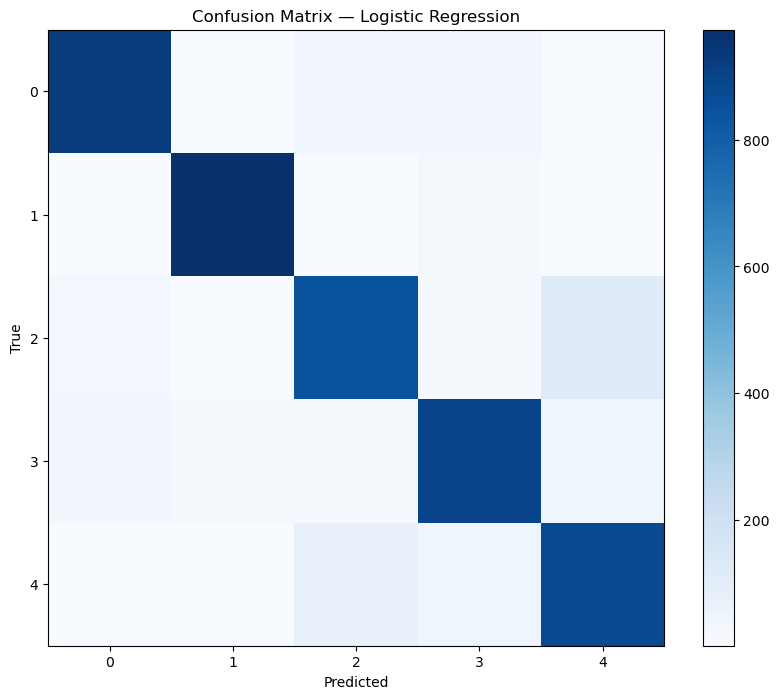

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1000
           1       0.97      0.97      0.97      1000
           2       0.88      0.84      0.86      1000
           3       0.89      0.90      0.89      1000
           4       0.84      0.88      0.86      1000

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



In [13]:
cm = confusion_matrix(y_test_5, lr_pred)
plt.figure(figsize=(10,8))
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_test_5, lr_pred))

# ROC Curves of Logistic Regression

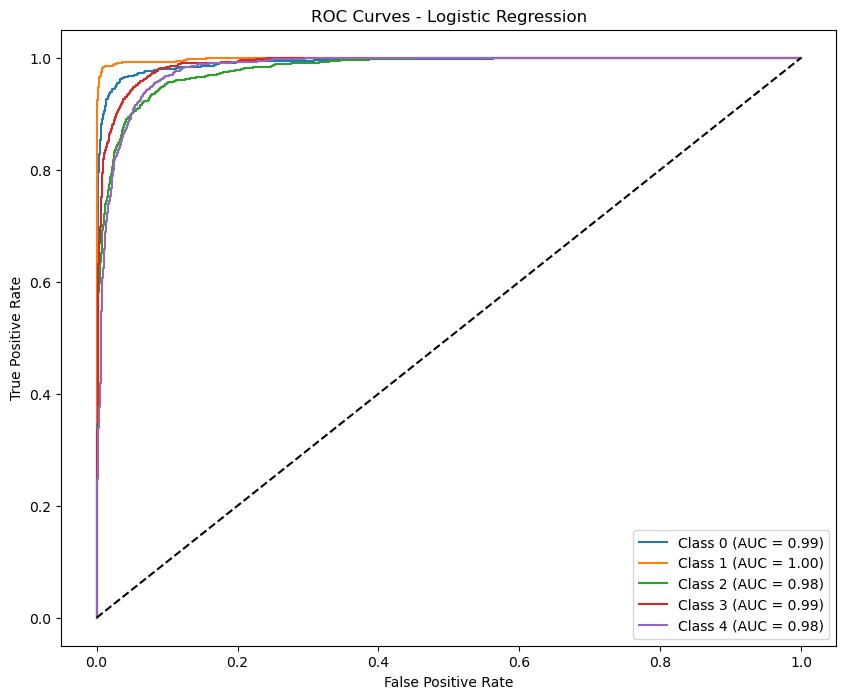

In [14]:
# Binarize the output
y_test_bin = label_binarize(y_test_5, classes=[0,1,2,3,4])
y_score = lr.predict_proba(X_test_final)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Logistic Regression')
plt.legend()
plt.show()

# k-means

In [15]:
kmeans = KMeans(n_clusters=5, random_state=7, n_init=10)
kmeans.fit(X_train_final)
kmeans_test_labels = kmeans.predict(X_test_final)

print("K-Means Cluster Labels (first 20 cluster):", kmeans_test_labels[:20])

K-Means Cluster Labels (first 20 cluster): [0 3 4 4 1 0 0 1 2 2 1 4 2 4 2 1 4 2 3 3]


In [16]:
def align_clusters(cluster_labels, true_labels):
    aligned_labels = np.zeros_like(cluster_labels)
    
    for cluster in range(5):
        mask = (cluster_labels == cluster)
    
        if np.sum(mask) > 0:  # If cluster exists
            # Find most common true label in this cluster
            most_common_label = mode(true_labels[mask]).mode
            aligned_labels[mask] = most_common_label
    
    return aligned_labels

# Align K-Means labels
aligned_kmeans_labels = align_clusters(kmeans_test_labels, y_test_5)

# Calculate accuracy
kmeans_accuracy = accuracy_score(y_test_5, aligned_kmeans_labels)
print("K-Means Accuracy: " +str(kmeans_accuracy))

K-Means Accuracy: 0.6554


# Confusion matrix ploting & classification report for K-Means

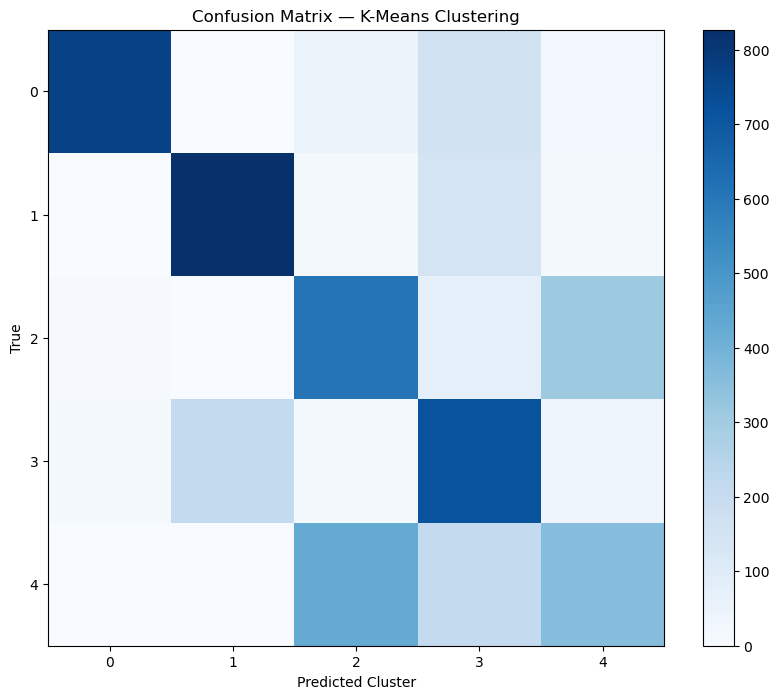

              precision    recall  f1-score   support

           0       0.97      0.77      0.86      1000
           1       0.79      0.83      0.81      1000
           2       0.54      0.61      0.58      1000
           3       0.55      0.72      0.62      1000
           4       0.49      0.36      0.41      1000

    accuracy                           0.66      5000
   macro avg       0.67      0.66      0.65      5000
weighted avg       0.67      0.66      0.65      5000



In [17]:
# Confusion matrix for K-Means
cm_kmeans = confusion_matrix(y_test_5, aligned_kmeans_labels)

plt.figure(figsize=(10,8))
plt.imshow(cm_kmeans, cmap="Blues")
plt.colorbar()
plt.title("Confusion Matrix — K-Means Clustering")
plt.xlabel("Predicted Cluster")
plt.ylabel("True")
plt.show()

# Classification report
print(classification_report(y_test_5, aligned_kmeans_labels))